In [1]:
import numpy as np
import nestle
import corner
import matplotlib.pyplot as plt

In [2]:
from settings import lightcurve_dir, config_dir, template_dir
from lightcurve import LightCurve, Outburst, read_template
from utils import read_outburst_numbers, read_priors

In [3]:
outburst_numbers = read_outburst_numbers(filename=config_dir+'outburst_numbers.txt')

In [4]:
lightcurve_detections_file = lightcurve_dir + "OJ287_Vmag.txt"
lightcurve_nondetections_file = lightcurve_dir + "OJ287_Vmag_upper.txt"

lightcurve_detections = LightCurve(lightcurve_detections_file)
lightcurve_nondetections = LightCurve(lightcurve_nondetections_file, Mref=lightcurve_detections.Mref)

In [5]:
cuts = np.genfromtxt(config_dir+"lightcurve_cuts.txt")

In [6]:
labels = [int(cut_min) for cut_min,cut_max in cuts]

In [7]:
priors = read_priors(config_dir+"priors.txt")

In [8]:
templates = [read_template(template_dir+"oj287_templ_all.txt".format(label)) for label in labels]

In [9]:
outbursts = [Outburst(outburst_numbers[label], lightcurve_detections, lightcurve_nondetections, cut, prior, template, label=label) for cut,prior,template,label in zip(cuts,priors,templates,labels)]

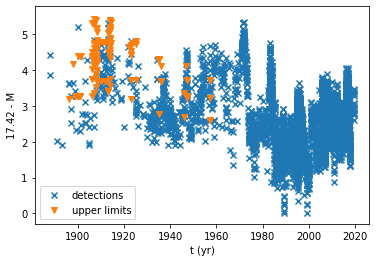

In [10]:
# Figure 1

def plot_full_lightcurve(lightcurve_det, lightcurve_cen):
    plt.scatter(lightcurve_det.t, lightcurve_det.M, marker='x', label="detections")
    plt.scatter(lightcurve_cen.t, lightcurve_cen.M, marker='v', label='upper limits')
    plt.xlabel("t (yr)")
    plt.ylabel("{} - M".format(lightcurve_det.Mref))
    plt.legend()
    plt.show()

plot_full_lightcurve(lightcurve_detections, lightcurve_nondetections)

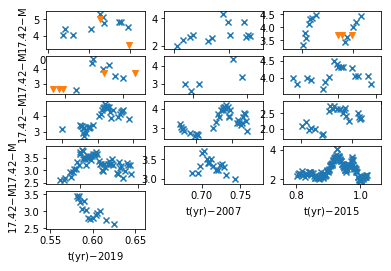

In [11]:
# Figure 2

def plot_outburst_lightcurves(outbursts):
    no_of_obs = len(outbursts)
    no_of_cols = 3
    no_of_rows = int(np.ceil(no_of_obs/no_of_cols))
    
    for idx, outburst in enumerate(outbursts):
        plt.subplot(no_of_rows, no_of_cols, idx+1)
        
        plt.scatter(outburst.lightcurve_det.t-outburst.year, outburst.lightcurve_det.M, marker='x')
        plt.scatter(outburst.lightcurve_cen.t-outburst.year, outburst.lightcurve_cen.M, marker='v')
        
        plt.xlabel("t(yr)$-${}".format(outburst.year))
        
        if idx%3==0:
            plt.ylabel("{}$-$M".format(outburst.lightcurve_det.Mref))
        
    plt.show()

plot_outburst_lightcurves(outbursts)

In [12]:
# Table 2

for ob in outbursts:
    print(ob.nob, ob.year, len(ob.lightcurve_det.t), len(ob.lightcurve_cen.t))

5 1912 10 2
8 1934 13 0
11 1947 12 3
12 1957 7 5
14 1964 5 0
16 1972 17 0
17 1982 35 0
18 1984 35 0
20 1995 22 0
21 2005 53 0
22 2007 18 0
23 2015 131 0
24 2019 15 0


In [13]:
param_labels = ["$t_{ob}$ (yr)", "$\\Delta M$", "$s$", "$A$", "$\\varsigma$"]

In [14]:
def maxlike(result):
    idx = np.argmax(result.logl)
    return result.samples[idx]

In [15]:
def plot_fit(outburst, params):
    plt.scatter(outburst.lightcurve_det.t, outburst.lightcurve_det.M)
    plt.scatter(outburst.lightcurve_cen.t, outburst.lightcurve_cen.M)
    tmpl_to_obs = outburst.templ_to_obs(params)
    plt.plot(tmpl_to_obs.t, tmpl_to_obs.M)
    plt.axvline(params[0])

In [16]:
years, bandwidths = np.genfromtxt("../../data/config/bandwidths.txt").transpose()
for ob, bw in zip(outbursts, bandwidths):
    ob.run_sampler()
    ob.process_samples(bw)
    #ob.save_samples("1tmpl/oj287_tobs_samples_{}.txt".format(ob.year))
    #ob.save_kde("1tmpl/oj287_tobs_kde_{}.txt".format(ob.year))

Running sampler for year 1912


/home/abhimanyu/.local/lib/python3.6/site-packages/nestle.py:906: RuntimeWarning: invalid value encountered in double_scalars
  math.exp(logz - logz_new) * (h + logz) -


Running sampler for year 1934
Running sampler for year 1947
Running sampler for year 1957
Running sampler for year 1964
Running sampler for year 1972
Running sampler for year 1982
Running sampler for year 1984
Running sampler for year 1995
Running sampler for year 2005
Running sampler for year 2007
Running sampler for year 2015
Running sampler for year 2019


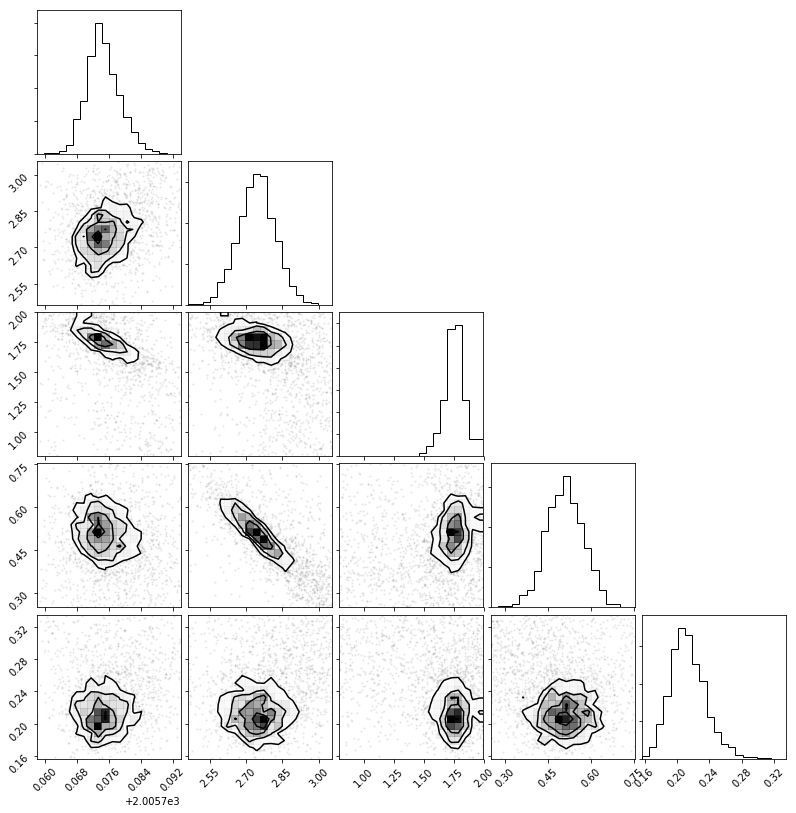

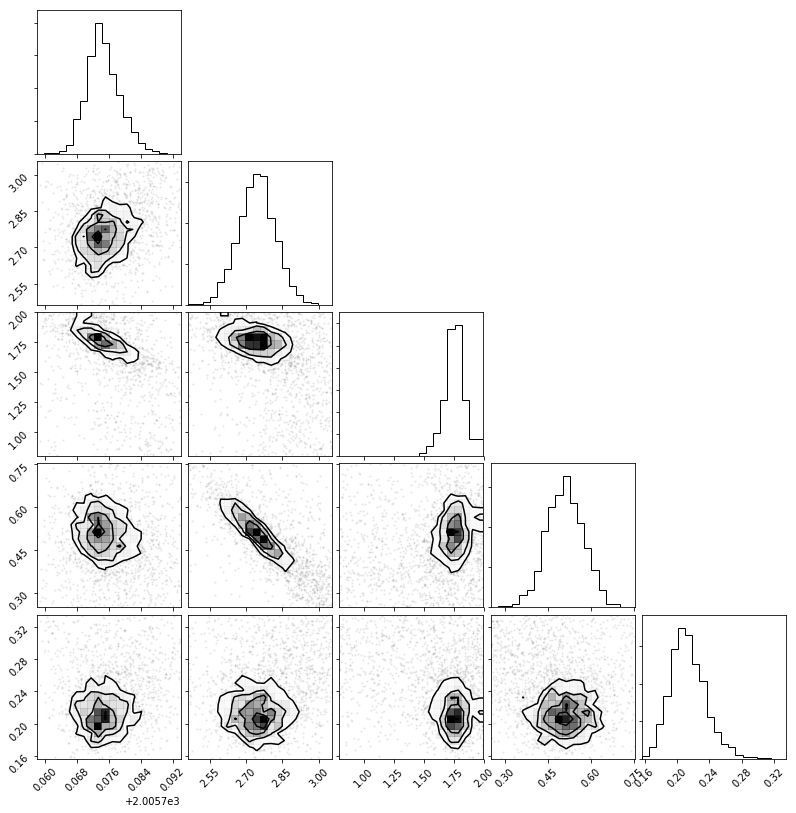

In [17]:
ob = outbursts[-4]
corner.corner(ob.result.samples, weights=ob.result.weights, range=[0.9999]*5)

2019.5655998623408


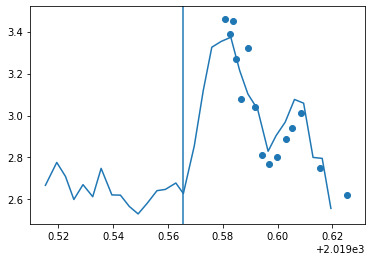

In [20]:
ob = outbursts[-1]
res = ob.result

tob = corner.quantile(res.samples[:,0], 0.5, weights=res.weights)[0]
dM = corner.quantile(res.samples[:,1], 0.5, weights=res.weights)[0]
s = corner.quantile(res.samples[:,2], 0.5, weights=res.weights)
A = corner.quantile(res.samples[:,3], 0.5, weights=res.weights)

print(tob)

model = ob.templ_to_obs([tob,dM,s,A])
plt.plot(model.t, model.M)
plt.scatter(ob.lightcurve_det.t, ob.lightcurve_det.M)
plt.scatter(ob.lightcurve_cen.t, ob.lightcurve_cen.M)
plt.axvline(tob)

[1912.9997303605385]
[1934.1396062896988]
[1947.1928876805596]
[1957.116295079324]
[1964.2378562679235]
[1972.9499549374355]
[1982.9945022876063]
[1984.1487261030888]
[1995.8421047858772]
[2005.7747040241268]
[2007.691956300985]
[2015.897045603916]
[2019.5655998623408]


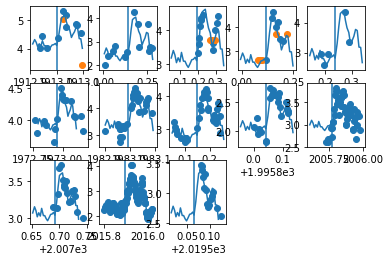

In [18]:
# Add a new figure if needed.

for idx,ob in enumerate(outbursts):
    res = ob.result
    
    tob = corner.quantile(res.samples[:,0], 0.5, weights=res.weights)
    dM = corner.quantile(res.samples[:,1], 0.5, weights=res.weights)
    s = corner.quantile(res.samples[:,2], 0.5, weights=res.weights)
    A = corner.quantile(res.samples[:,3], 0.5, weights=res.weights)
    
    print(tob)
    
    plt.subplot(3,5,idx+1)
    model = ob.templ_to_obs([tob,dM,s,A])
    plt.plot(model.t, model.M)
    plt.scatter(ob.lightcurve_det.t, ob.lightcurve_det.M)
    plt.scatter(ob.lightcurve_cen.t, ob.lightcurve_cen.M)
    plt.axvline(tob)

5 1912.9997 0.0099
8 1934.1390 0.0100
11 1947.1927 0.0036
12 1957.1170 0.0070
14 1964.2384 0.0180
16 1972.9503 0.0107
17 1982.9946 0.0014
18 1984.1488 0.0011
20 1995.8421 0.0023
21 2005.7742 0.0037
22 2007.6919 0.0010
23 2015.8971 0.0005
24 2019.5657 0.0027


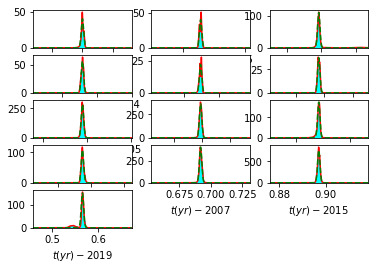

In [20]:
# Table 3
# Figure 5(a)

years, bandwidths = np.genfromtxt("../../data/config/bandwidths.txt").transpose()

for idx,(ob,bw) in enumerate(zip(outbursts,bandwidths)):
    ob.process_samples(bw)
    
    tob_med = corner.quantile(ob.result.samples[:,0], 0.5, weights=ob.result.weights)[0]
    samples = nestle.resample_equal(ob.result.samples[:,0], weights=ob.result.weights)
    
    samples_d = samples - ob.year
    median = np.median(samples_d)
    mad = np.median(np.abs(samples_d-median))
    std = 1.4826*mad
    print("{:d} {:0.4f} {:0.4f}".format(ob.nob, median+ob.year, std))
    
    plt.subplot(5,3,idx+1)
    
    left,right = median-40*std, median+40*std 
    plt.hist(samples_d, bins=64, density=True, color='cyan', range=[left,right])
    
    grid = np.linspace(left, right, 10000)
    pdf_kde = ob.kde.predict(grid[:,np.newaxis]+ob.year)
    plt.plot(grid, pdf_kde, color='r', label="KDE ({})".format(int(ob.year)))
      
    pdf_gauss = 1/np.sqrt(2*np.pi)/std * np.exp(-0.5*((grid-median)/std)**2)
    plt.plot(grid, pdf_gauss, color='green', label="KDE ({})".format(int(ob.year)), ls='--')
    
    plt.xlim([left,right])
    
    plt.xlabel("$t (yr)-{}$".format(ob.year))
    
    kde_save = np.array([grid+ob.year, np.log(pdf_kde)]).transpose()
    np.savetxt("1tmpl/oj287_tobs_samples_{}.txt".format(ob.year), samples)
    np.savetxt("1tmpl/oj287_tobs_kde_{}.txt".format(ob.year), kde_save)

In [21]:
import NoSpin_py as nospin

ImportError: /usr/lib/x86_64-linux-gnu/libboost_python3-py36.so.1.65.1: undefined symbol: PyUnicode_AsUTF8String

In [ ]:
z = 0.306
year = 365.25*24*3600

In [ ]:
phiobs = np.pi*np.array([ob.nob for ob in outbursts])
tobs = np.array([ob.median for ob in outbursts])
toberrs = np.array([ob.nmad for ob in outbursts])
lnlike_gauss = nospin.Likelihood(phiobs, tobs*year, toberrs*year, z)

In [ ]:
lnlike_kde = nospin.KDELikelihood(z)
for ob in outbursts:
    lnlike_kde.add_distr(np.pi*ob.nob, ob.kde_grid*year, np.log(ob.kde_vals/year), ob.median*year, ob.nmad*year)

In [ ]:
def prior_transform_fn(datafile, nparams):
    units, prmin, prmax = np.genfromtxt(datafile)
    prmin *= units
    prmax *= units
    spans = prmax-prmin
    def prior_transform(cube):
        return prmin + spans*cube

    if len(prmin) != nparams:
        raise ValueError()
    
    return prior_transform

In [ ]:
prior_transform = prior_transform_fn("../../data/config/nospin_priors.txt", nospin.N_PARAMS)

gauss_result = nestle.sample(lnlike_gauss, prior_transform, nospin.N_PARAMS, npoints=100, method='multi', 
                             callback=nestle.print_progress)

In [ ]:
corner.corner(gauss_result.samples, weights=gauss_result.weights, range=[0.9999]*nospin.N_PARAMS)

In [ ]:
prior_transform = prior_transform_fn("../../data/config/nospin_priors.txt", nospin.N_PARAMS)

kde_result = nestle.sample(lnlike_kde, prior_transform, nospin.N_PARAMS, npoints=100, method='multi', 
                             callback=nestle.print_progress)

In [ ]:
MSun = 4.92703806e-6

samples = kde_result.samples.copy()
samples[:,3] /= year
samples[:,3] -= 1886
samples[:,4] /= MSun*1e10

nospin_labels = ["$x_0$", "$e_{t0}$", "$u_{0}$ (rad)", "$t_{0}$ (yr)-1886", "$M\\,(10^{10}M_{\\odot})$", "$\\eta$", "$d_{em}$", "$d_{dd}$"]

corner.corner(samples, weights=kde_result.weights, range=[0.99999]*nospin.N_PARAMS, labels=nospin_labels, label_kwargs={"fontsize":14})

In [ ]:
x0_samples = kde_result.samples[:,0]
M_samples = kde_result.samples[:,4]
nb0_samples = x0_samples**1.5 / M_samples
Pb0E_year_samples = (1+z)*2*np.pi/nb0_samples/year
plt.hist(Pb0E_year_samples, weights=kde_result.weights, range=[11.06,11.13], bins=32)

In [ ]:
#############################################################################

In [ ]:
templates_rr = [read_template(template_dir+"oj287_templ_{}.txt".format(label)) for label in labels]

In [ ]:
outbursts_rr = [Outburst(outburst_numbers[label], lightcurve_detections, lightcurve_nondetections, cut, prior, template, label=label) for cut,prior,template,label in zip(cuts,priors,templates_rr,labels)]

In [ ]:
for ob in outbursts_rr:
    ob.run_sampler()
    ob.process_samples(bw)

In [ ]:
for idx,ob in enumerate(outbursts_rr):
    res = ob.result
    
    tob = corner.quantile(res.samples[:,0], 0.5, weights=res.weights)
    dM = corner.quantile(res.samples[:,1], 0.5, weights=res.weights)
    s = corner.quantile(res.samples[:,2], 0.5, weights=res.weights)
    A = corner.quantile(res.samples[:,3], 0.5, weights=res.weights)
    
    print(tob)
    
    plt.subplot(3,5,idx+1)
    model = ob.templ_to_obs([tob,dM,s,A])
    plt.plot(model.t, model.M)
    plt.scatter(ob.lightcurve_det.t, ob.lightcurve_det.M)
    plt.scatter(ob.lightcurve_cen.t, ob.lightcurve_cen.M)
    plt.axvline(tob)

In [ ]:
# Figure 5(b)
# Table 3

for idx,(ob,bw) in enumerate(zip(outbursts_rr,bandwidths)):
    tob_med = corner.quantile(ob.result.samples[:,0], 0.5, weights=ob.result.weights)[0]
    samples = nestle.resample_equal(ob.result.samples[:,0], weights=ob.result.weights)
    samples_d = samples - ob.year
    
    median = np.median(samples_d)
    mad = np.median(np.abs(samples_d-median))
    std = 1.4826*mad
    print("{:d} {:0.4f} {:0.4f}".format(ob.nob, median+ob.year, std))
    
    plt.subplot(5,3,idx+1)
   
    left,right = median-7*std, median+7*std  #corner.quantile(samples_d, [0.001,0.999])
    plt.hist(samples_d, bins=64, density=True, color='cyan', range=[left,right])
    
    grid = np.linspace(2*min(samples)-max(samples), 2*max(samples)-min(samples), 1000)
    pdf_kde = ob.kde.predict(grid[:,np.newaxis])
    plt.plot(grid-ob.year, pdf_kde, color='r', label="KDE ({})".format(int(ob.year)))
    
    pdf_gauss = 1/np.sqrt(2*np.pi)/std * np.exp(-0.5*((grid-ob.year-median)/std)**2)
    plt.plot(grid-ob.year, pdf_gauss, color='green', label="KDE ({})".format(int(ob.year)), ls='--')
        
    plt.xlim([left,right])
    plt.xlabel("$t (yr)-{}$".format(ob.year))

In [ ]:
phiobs_rr = np.pi*np.array([ob.nob for ob in outbursts_rr])
tobs_rr = np.array([ob.median for ob in outbursts_rr])
toberrs_rr = np.array([ob.nmad for ob in outbursts_rr])
lnlike_gauss_rr = nospin.Likelihood(phiobs_rr, tobs_rr*year, toberrs_rr*year, z)

In [ ]:
lnlike_kde_rr = nospin.KDELikelihood(z)
for ob in outbursts_rr:
    lnlike_kde_rr.add_distr(np.pi*ob.nob, ob.kde_grid*year, np.log(ob.kde_vals/year), ob.median*year, ob.nmad*year)

In [ ]:
prior_transform = prior_transform_fn("../../data/config/nospin_priors.txt", nospin.N_PARAMS)

gauss_result_rr = nestle.sample(lnlike_gauss_rr, prior_transform, nospin.N_PARAMS, npoints=100, method='multi', 
                             callback=nestle.print_progress)

In [ ]:
corner.corner(gauss_result_rr.samples, weights=gauss_result_rr.weights, range=[0.99999]*nospin.N_PARAMS)

In [ ]:
kde_result_rr = nestle.sample(lnlike_kde_rr, prior_transform, nospin.N_PARAMS, npoints=100, method='multi', 
                             callback=nestle.print_progress)

In [ ]:
samples_rr = kde_result_rr.samples.copy()
samples_rr[:,3] /= year
samples_rr[:,3] -= 1886
samples_rr[:,4] /= MSun*1e10

corner.corner(samples_rr, weights=kde_result_rr.weights, range=[0.9999]*nospin.N_PARAMS, 
              labels=nospin_labels, label_kwargs={"fontsize":14})

In [ ]:
x0_samples_rr = kde_result_rr.samples[:,0]
M_samples_rr = kde_result_rr.samples[:,4]
nb0_samples_rr = x0_samples_rr**1.5 / M_samples_rr
Pb0E_year_samples_rr = (1+z)*2*np.pi/nb0_samples_rr/year
plt.hist(Pb0E_year_samples_rr, weights=kde_result_rr.weights, density=True, range=[11.06,11.13], bins=32, color='r', label="Round-robin")
plt.hist(Pb0E_year_samples, weights=kde_result.weights, density=True, range=[11.06,11.13], bins=32,  color='b', alpha=0.5, label="Single Template")
plt.legend()
plt.xlabel("$P_{b0}^E$")